In [1]:
#Import Libraries
import pandas as pd
import nltk as nltk
import numpy
from nltk.corpus import stopwords
import keras
import re
import string
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Activation, Dropout
from keras.optimizers import RMSprop, Adam
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers.embeddings import Embedding


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Mount drive to access files in gdrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
# Read Train, Test and Gold dataset
df_train = pd.read_csv("/content/gdrive/MyDrive/NLP_Project/train.csv")
df_test = pd.read_csv("/content/gdrive/MyDrive/NLP_Project/dev.csv")
df_gold = pd.read_csv("/content/gdrive/MyDrive/NLP_Project/gold-test.csv")

In [5]:
# Preprocessing data lowercase and removing hyperlinks and stopwords
stop_words = set(stopwords.words('english'))  
def preProcessData(data_frame):
    data_frame['text'] = (data_frame['text']).str.lower()
    data_frame['text'] = data_frame['text'].apply(lambda x: re.sub(r"^https?:\/\/.*[\r\n]*", "", x, flags=re.MULTILINE))
    data_frame['text'] = data_frame['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    return data_frame

In [6]:
# Creating train, test and gold labels
X_train = preProcessData(df_train)['text']
X_test = preProcessData(df_test)['text']
X_gold = preProcessData(df_gold)['text']
Y_train = df_train['is_humor']
Y_test = df_test['is_humor']
Y_gold = df_gold['is_humor']

In [7]:
# Bag-of-words vectorization
cv = CountVectorizer() 
vect = cv.fit(X_train)
Bagofwords_train = vect.transform(X_train).toarray()
Bagofwords_test = cv.transform(X_test).toarray()
Bagofwords_gold = cv.transform(X_gold).toarray()


In [8]:
# Metrics Calculation

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    print(recall)
    return recall
# calculating precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    print('precesion', precision)
    return precision
# calculating F1 Score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
%%time
# Initializing Model 
model = Sequential()
model.add(Embedding(100000, 100, input_length=50, trainable=False))
model.add(LSTM(100))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy',f1_m, precision_m, recall_m])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           10000000  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 10,093,457
Trainable params: 93,457
Non-trainable params: 10,000,000
_________________________________________________________________
CPU times: user 716 ms, sys: 351 ms, total: 1.07 s
Wall time: 1.01 s


In [10]:
# Training the model
%%time
model.fit(Bagofwords_train,  Y_train, epochs=7, batch_size= 128)

Epoch 1/7
precesion Tensor("truediv:0", shape=(), dtype=float32)
Tensor("truediv_1:0", shape=(), dtype=float32)
precesion Tensor("truediv_3:0", shape=(), dtype=float32)
Tensor("truediv_4:0", shape=(), dtype=float32)
precesion Tensor("truediv:0", shape=(), dtype=float32)
Tensor("truediv_1:0", shape=(), dtype=float32)
precesion Tensor("truediv_3:0", shape=(), dtype=float32)
Tensor("truediv_4:0", shape=(), dtype=float32)
63/63 [==============================] - 80s 971ms/step - loss: 0.6726 - binary_accuracy: 0.6065 - f1_m: 0.7511 - precision_m: 0.6130 - recall_m: 0.9762
Epoch 2/7
63/63 [==============================] - 61s 963ms/step - loss: 0.6661 - binary_accuracy: 0.6184 - f1_m: 0.7632 - precision_m: 0.6184 - recall_m: 1.0000
Epoch 3/7
63/63 [==============================] - 61s 964ms/step - loss: 0.6634 - binary_accuracy: 0.6226 - f1_m: 0.7669 - precision_m: 0.6226 - recall_m: 1.0000
Epoch 4/7
63/63 [==============================] - 61s 966ms/step - loss: 0.6667 - binary_accuracy:

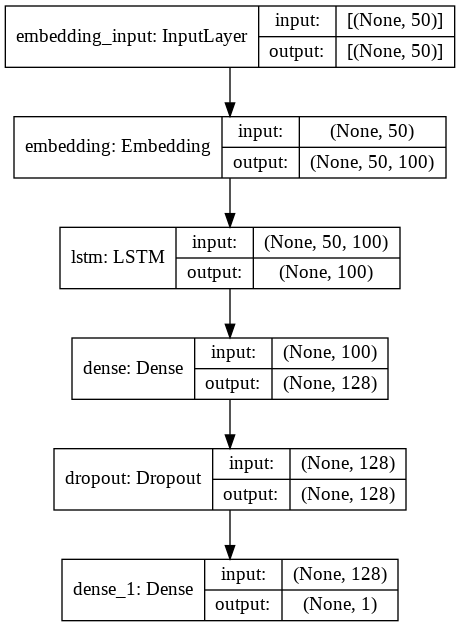

In [11]:
# Plotting model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
# Evaluating Model
test_accuracy = model.evaluate(Bagofwords_test, Y_test)
gold_accuracy = model.evaluate(Bagofwords_gold, Y_gold)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}\n F1 Score:{:0.3f}'.format(test_accuracy[0],test_accuracy[1], test_accuracy[2]))
print('Gold set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}\n F1 Score:{:0.3f}'.format(gold_accuracy[0],gold_accuracy[1], gold_accuracy[2]))

precesion Tensor("truediv:0", shape=(), dtype=float32)
Tensor("truediv_1:0", shape=(), dtype=float32)
precesion Tensor("truediv_3:0", shape=(), dtype=float32)
Tensor("truediv_4:0", shape=(), dtype=float32)
32/32 [==============================] - 7s 217ms/step - loss: 0.6665 - binary_accuracy: 0.6150 - f1_m: 0.7616 - precision_m: 0.6211 - recall_m: 1.0000
Test set
  Loss: 0.659
  Accuracy: 0.632
 F1 Score:0.771
Gold set
  Loss: 0.667
  Accuracy: 0.615
 F1 Score:0.762
